# 神经网络模型图示
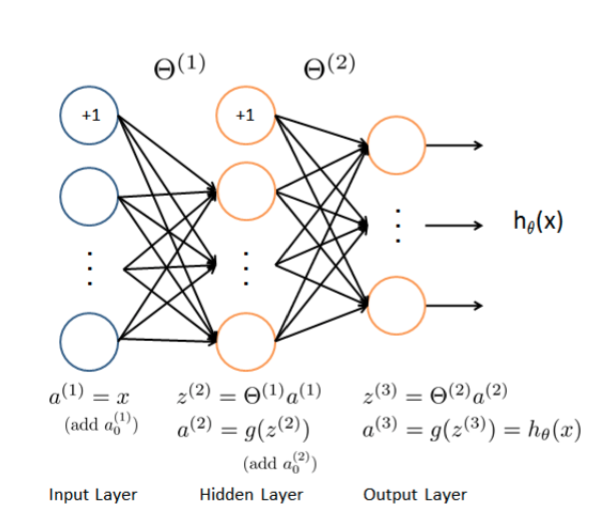

In [82]:
import math
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
#import pandas as pd
import scipy.io as sio
import scipy.optimize as opt
from sklearn.metrics import classification_report

In [122]:
## Setup the parameters you will use for this exercise
input_layer_size  = 400;  # 20x20 Input Images of Digits
hidden_layer_size = 25;   # 25 hidden units
num_labels = 10;          # 10 labels, from 1 to 10   
                          # (note that we have mapped "0" to label 10)

# Loading and Visualizing Data
---
We start the exercise by first loading and visualizing the dataset.  
You will be working with a dataset that contains handwritten digits.  

In [3]:
data = sio.loadmat('HandwrittenDigitsData.mat')
X = data['X']
y = data.get('y')
X.shape, y.shape, data

((5000, 400),
 (5000, 1),
 {'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
  '__version__': '1.0',
  '__globals__': [],
  'X': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  'y': array([[10],
         [10],
         [10],
         ...,
         [ 9],
         [ 9],
         [ 9]], dtype=uint8)})

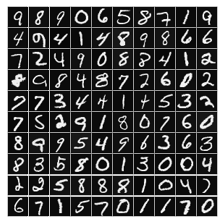

In [4]:
# Randomly select 100 data points to display
fig = plt.figure(dpi=41, num=1, figsize=(5, 5))
X_show_100 = X[np.random.randint(0, X.shape[0], 100),:]
for i in range(1, 101):
    ax = fig.add_subplot(10, 10, i)
    ax.imshow(X_show_100[i-1,:].reshape(20, 20).T, cmap='gray')
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.tight_layout(-1)
plt.show()

# Loading Parameters
---
In this part of the exercise, we load some pre-initialized neural network parameters.  

In [5]:
weights = sio.loadmat('PresetWeights.mat')
Theta1 = weights['Theta1']
Theta2 = weights.get('Theta2')
Theta1.shape, Theta2.shape, weights

((25, 401),
 (10, 26),
 {'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Oct 18 14:57:02 2011',
  '__version__': '1.0',
  '__globals__': [],
  'Theta1': array([[-2.25623899e-02, -1.05624163e-08,  2.19414684e-09, ...,
          -1.30529929e-05, -5.04175101e-06,  2.80464449e-09],
         [-9.83811294e-02,  7.66168682e-09, -9.75873689e-09, ...,
          -5.60134007e-05,  2.00940969e-07,  3.54422854e-09],
         [ 1.16156052e-01, -8.77654466e-09,  8.16037764e-09, ...,
          -1.20951657e-04, -2.33669661e-06, -7.50668099e-09],
         ...,
         [-1.83220638e-01, -8.89272060e-09, -9.81968100e-09, ...,
           2.35311186e-05, -3.25484493e-06,  9.02499060e-09],
         [-7.02096331e-01,  3.05178374e-10,  2.56061008e-09, ...,
          -8.61759744e-04,  9.43449909e-05,  3.83761998e-09],
         [-3.50933229e-01,  8.85876862e-09, -6.57515140e-10, ...,
          -1.80365926e-06, -8.14464807e-06,  8.79454531e-09]]),
  'Theta2': array([[-0.76100352, -1.21244

In [6]:
def sigmoid(z): 
    return 1.0 / (1.0 + np.exp(-z))
    #return 1.0 / (1.0 + np.power(math.e, -z))

In [7]:
def predict(Theta1, Theta2, X):
    # Outputs the predicted label of X given the trained weights (Theta1, Theta2)
    m, n = X.shape    
    a1 = np.hstack((np.ones([m, 1]), X))
    z2 = a1 @ Theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(sigmoid(z2).shape[0]), axis=1)
    z3 = a2 @ Theta2.T
    a3 = h = sigmoid(z3)
    return np.argmax(h, axis=1) + 1

In [8]:
# 使用预设的权重参数进行预测，查看准确率
# y[y==10] = 0
print(classification_report(y, predict(Theta1, Theta2, X)))
# or
print('Accuracy = {0}%'.format(np.mean(y==np.matrix(predict(Theta1, Theta2, X)).T) * 100))

              precision    recall  f1-score   support

           1       0.97      0.98      0.98       500
           2       0.98      0.97      0.98       500
           3       0.98      0.96      0.97       500
           4       0.97      0.97      0.97       500
           5       0.97      0.98      0.98       500
           6       0.98      0.99      0.98       500
           7       0.98      0.97      0.97       500
           8       0.98      0.98      0.98       500
           9       0.97      0.96      0.96       500
          10       0.98      0.99      0.99       500

   micro avg       0.98      0.98      0.98      5000
   macro avg       0.98      0.98      0.98      5000
weighted avg       0.98      0.98      0.98      5000

Accuracy = 97.52%


# Compute Cost (Feedforward)  
---

To the neural network, you should first start by implementing the feedforward part of the neural network that returns the cost only. You should complete the code in nnCostFunction.m to return cost. After implementing the feedforward to compute the cost, you can verify that your implementation is correct by verifying that you get the same cost as us for the fixed debugging parameters.  

We suggest implementing the feedforward cost *without* regularization first so that it will be easier for you to debug. Later, in part 4, you will get to implement the regularized cost.  

$$\begin{align}
J(\theta)= & \frac{1}{m}\sum\limits_{i=1}^{m}\sum\limits_{k=1}^{K}\Bigg[-y_k^{(i)}log\Big(\big(h_{\theta}(x^{(i)})\big)_k\Big) - (1-y_k^{(i)})log\Big(1-\big(h_{\theta}(x^{(i)})\big)_k\Big)\Bigg] + \\ 
& \frac{\lambda}{2m}\Bigg[\sum\limits_{j=1}^{25}\sum\limits_{k=1}^{400}\big(\Theta_{j,k}^{(1)}\big)^2 + \sum\limits_{j=1}^{10}\sum\limits_{k=1}^{25}\big(\Theta_{j,k}^{(2)}\big)^2 \Bigg] \\
\end{align}$$

$$
\begin{align} 
J(\Theta)= & - \frac{1}{m} \cdot \sum\limits_{i=1}^m \Bigg[ y^{(i)} log \big( h_\theta(x^{(i)}) \big) +(1-y^{(i)}) log \big(1 - h_\theta(x^{(i)}) \big) \Bigg]  \\  
 & + \frac{\lambda}{2m} \sum\limits_{j=1}^{n} \theta_j^2 \quad \text{逻辑回归代价函数} \\
J(\Theta)= & - \frac{1}{m} \cdot \sum\limits_{i=1}^m \sum\limits_{k=1}^K \Bigg[ y_k^{(i)} log \Big( \big( h_\Theta(x^{(i)}) \big)_k \Big) +(1-y_k^{(i)}) log \Big(1 - \big( h_\Theta(x^{(i)}) \big)_k \Big) \Bigg] \\ 
 & + \frac{\lambda}{2m} \sum\limits_{l=1}^{L-1} \sum\limits_{i=1}^{S_l} \sum\limits_{j=1}^{S_{l+1}} \big( \Theta_{j i}^{(l)} \big)^2 \quad \text{神经网络代价函数} 
\end{align} 
$$

In [32]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
 
    m, n = X.shape
    
    Theta1 = nn_params[0:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, (input_layer_size + 1))
    Theta2 = nn_params[hidden_layer_size * (input_layer_size + 1):].reshape(num_labels, (hidden_layer_size + 1))
    
    # Transfer y - one hot encoder
    y_onehot = np.zeros([m, num_labels]); 
    for j in range(m): y_onehot[j,int(y[j,0])-1] = 1
    # or you can use sklearn package below to implement it
    #from sklearn.preprocessing import OneHotEncoder
    #encoder = OneHotEncoder(sparse=False)
    #y_onehot = encoder.fit_transform(y)
    #y_onehot.shape

    # Feedforward
    a1 = np.insert(X, 0, values=np.ones(m), axis=1)
    z2 = a1 @ Theta1.T
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2 @ Theta2.T
    a3 = h = sigmoid(z3);
    
    # compute J.
    loss = -np.multiply(y_onehot, np.log(h)) - np.multiply((1 - y_onehot), np.log(1 - h))
    loss = loss.sum() / m
    
    theta1_bias_0 = Theta1.copy()
    theta2_bias_0 = Theta2.copy()
    theta1_bias_0[:, 0] = 0
    theta2_bias_0[:, 0] = 0
    
    loss_reg = np.power(theta1_bias_0, 2).sum() + np.power(theta2_bias_0, 2).sum()
    loss_reg = loss_reg * Lambda / 2 / m

    # Backpropagation algorithm to compute grad.
    d3 = a3 - y_onehot; 
    d2 = np.multiply( d3 @ Theta2[:,1:], np.multiply(sigmoid(z2), 1 - sigmoid(z2)) )
    
    Theta2_grad = (d3.T @ a2) / m
    Theta1_grad = (d2.T @ a1) / m
    
    # regularization gradients
    Theta2_grad[:, 1:] = Theta2_grad[:,1:] + Theta2[:, 1:] * Lambda / m
    Theta1_grad[:, 1:] = Theta1_grad[:,1:] + Theta1[:, 1:] * Lambda / m

    # Return J and Gradients
    J = loss + loss_reg;
    grad = np.concatenate((np.ravel(Theta1_grad), np.ravel(Theta2_grad)))

    return J, grad

In [33]:
# Weight regularization parameter (we set this to 0 here).
# it should be about 0.287629
Lambda = 0
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda); J

0.2876291651613189

# Implement Regularization
---
Once your cost function implementation is correct, you should now continue to implement the regularization with the cost.

In [34]:
# Checking Cost Function with Regularization
# Weight regularization parameter (we set this to 1 here).
# J should be about 0.383770
Lambda = 1
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda); J

0.38376985909092365

# Sigmoid Gradient
---
Before you start implementing the neural network, you will first implement the gradient for the sigmoid function.

In [35]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), 1 - sigmoid(z))

In [14]:
# Evaluating sigmoid gradient...
# For large values (both positive and negative) of z, the gradient should be close to 0. 
# When z = 0, the gradient should be exactly 0.25.
print(sigmoid_gradient(-999))
print(sigmoid_gradient(-1))
print(sigmoid_gradient(-0.5))
print(sigmoid_gradient(0))
print(sigmoid_gradient(0.5))
print(sigmoid_gradient(1))
print(sigmoid_gradient(999))

0.0
0.19661193324148185
0.2350037122015945
0.25
0.2350037122015945
0.19661193324148185
0.0


# Initializing Pameters
---
In this part of the exercise, you will be starting to implment a two layer neural network that classifies digits. You will start by implementing a function to initialize the weights of the neural network (randInitializeWeights.m)

In [119]:
def randInitializeWeights(L_in, L_out, epsilon_init = 0.12):
    # Randomly initialize the weights of a layer with L_in incoming connections and L_out outgoing connections
    # Initialize randomly so that we break the symmetry while training the neural network.
    # Note: The first column corresponds to the parameters for the bias unit
    
    # There are two ways to implement it
    #return np.random.rand(L_out, 1 + L_in) * 2 * epsilon_init - epsilon_init
    return np.random.uniform(-epsilon_init, epsilon_init, [L_out, 1 + L_in])

In [121]:
# Initializing Neural Network Parameters ...
initial_Theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.concatenate((np.ravel(initial_Theta1), np.ravel(initial_Theta2)))

initial_Theta1.shape, initial_Theta2.shape, initial_nn_params.shape

((25, 401), (10, 26), (10285,))

# Implement Backpropagation
---
Once your cost matches up with ours, you should proceed to implement the backpropagation algorithm for the neural network. You should add to the code you've written in nnCostFunction.m to return the partial derivatives of the parameters.

In [17]:
def debugInitializeWeights(fan_in, fan_out):
    # Set W to zeros
    W = np.zeros([fan_out, 1 + fan_in]);
    # Initialize W using "sin", this ensures that W is always of the same values and will be useful for debugging
    return np.sin(range(1, np.size(W) + 1)).reshape(W.shape) / 10;

In [107]:
def computeNumericalGradient(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    Len = np.size(nn_params)
    numeric_grad = np.zeros(Len)
    perturb = np.zeros(Len)
    EPSILON = 1e-4
    for p in range(Len):
        # Set perturbation vector
        perturb[p] = EPSILON;
        loss1, _ = nnCostFunction(nn_params - perturb, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)
        loss2, _ = nnCostFunction(nn_params + perturb, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)
        # Compute Numerical Gradient
        numeric_grad[p] = (loss2 - loss1) / (2 * EPSILON)
        perturb[p] = 0;
    _, analytic_grad = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)
    return numeric_grad, analytic_grad

In [114]:
def checkNNGradients(Lambda=0):
# Creates a small neural network to check the backpropagation gradients
# It will output the analytical gradients produced by your backprop code 
# and the numerical gradients (computed using computeNumericalGradient). 
# These two gradient computations should result in very similar values.

    input_layer_size = 3;
    hidden_layer_size = 5;
    num_labels = 3;
    m = 5;

    # We generate some 'random' test data
    Theta1 = debugInitializeWeights(input_layer_size, hidden_layer_size);
    Theta2 = debugInitializeWeights(hidden_layer_size, num_labels);
    # Reusing debugInitializeWeights to generate X
    X  = debugInitializeWeights(input_layer_size - 1, m);
    y  = np.array([np.mod(range(1,6), np.ones(5)*3)]).T + 1

    # Unroll parameters(serialize)
    #nn_params = [Theta1(:) ; Theta2(:)];
    nn_params = np.concatenate((np.ravel(Theta1), np.ravel(Theta2)))
    # deserialize
    # seq[:25 * 401].reshape(25, 401), seq[25 * 401:].reshape(10, 26)

    numeric_grad, analytic_grad = computeNumericalGradient(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda)

    # Visually examine the two gradient computations.  The two columns
    # you get should be very similar. 
    print(np.vstack((numeric_grad, analytic_grad)).T)
    print()
    print('The above two columns you get should be very similar.')
    print('(Left-Your Numerical Gradient, Right-Analytical Gradient)')
    print()
    
    # Evaluate the norm of the difference between two solutions.  
    # If you have a correct implementation, and assuming you used EPSILON = 0.0001 
    # then diff below should be less than 1e-9
    diff = np.linalg.norm(numeric_grad - analytic_grad) / np.linalg.norm(numeric_grad + analytic_grad);

    print('If your backpropagation implementation is correct, ')
    print('then the relative difference will be small (less than 1e-9). ')
    print('Relative Difference: {0}'.format(diff))
    
    print()
    print('Debugging:')
    print('np.linalg.norm(numeric_grad - analytic_grad) : ' + str(np.linalg.norm(numeric_grad - analytic_grad)))
    print('np.linalg.norm(numeric_grad + analytic_grad) : ' + str(np.linalg.norm(numeric_grad + analytic_grad)))

In [115]:
# Check gradients by running checkNNGradients.
# In fact, the gradient is detected by the cost function.
# So, first, you must make sure your Cost Function is correct.
checkNNGradients()

[[ 1.23162247e-02  1.23162247e-02]
 [ 1.73828185e-04  1.73828184e-04]
 [ 2.61455146e-04  2.61455144e-04]
 [ 1.08701450e-04  1.08701450e-04]
 [ 3.92471369e-03  3.92471369e-03]
 [ 1.90101250e-04  1.90101252e-04]
 [ 2.22272334e-04  2.22272331e-04]
 [ 5.00872543e-05  5.00872547e-05]
 [-8.08459407e-03 -8.08459407e-03]
 [ 3.13170623e-05  3.13170587e-05]
 [-2.17840346e-05 -2.17840341e-05]
 [-5.48569878e-05 -5.48569864e-05]
 [-1.26669105e-02 -1.26669105e-02]
 [-1.56130209e-04 -1.56130210e-04]
 [-2.45506164e-04 -2.45506163e-04]
 [-1.09164882e-04 -1.09164881e-04]
 [-5.59342546e-03 -5.59342547e-03]
 [-2.00036570e-04 -2.00036572e-04]
 [-2.43630216e-04 -2.43630220e-04]
 [-6.32313668e-05 -6.32313673e-05]
 [ 3.09347722e-01  3.09347722e-01]
 [ 1.61067138e-01  1.61067138e-01]
 [ 1.47036522e-01  1.47036522e-01]
 [ 1.58268577e-01  1.58268577e-01]
 [ 1.57616707e-01  1.57616707e-01]
 [ 1.47236360e-01  1.47236360e-01]
 [ 1.08133003e-01  1.08133003e-01]
 [ 5.61633717e-02  5.61633717e-02]
 [ 5.19510542e-02  5

# Implement Regularization
---
Once your backpropagation implementation is correct, you should now continue to implement the regularization with the cost and gradient.

In [116]:
# Checking Backpropagation with Regularization ...
# Check gradients by running checkNNGradients
Lambda = 3;
checkNNGradients(Lambda);

[[ 0.01231622  0.01231622]
 [ 0.05473167  0.05473167]
 [ 0.00872866  0.00872866]
 [-0.04529945 -0.04529945]
 [ 0.00392471  0.00392471]
 [-0.01657483 -0.01657483]
 [ 0.03964147  0.03964147]
 [ 0.05941158  0.05941158]
 [-0.00808459 -0.00808459]
 [-0.03260995 -0.03260995]
 [-0.0600212  -0.0600212 ]
 [-0.03224923 -0.03224923]
 [-0.01266691 -0.01266691]
 [ 0.05928031  0.05928031]
 [ 0.03877176  0.03877176]
 [-0.01738336 -0.01738336]
 [-0.00559343 -0.00559343]
 [-0.04525927 -0.04525927]
 [ 0.008749    0.008749  ]
 [ 0.05471348  0.05471348]
 [ 0.30934772  0.30934772]
 [ 0.21562498  0.21562498]
 [ 0.15550372  0.15550372]
 [ 0.11286043  0.11286043]
 [ 0.10008125  0.10008125]
 [ 0.13047143  0.13047143]
 [ 0.108133    0.108133  ]
 [ 0.11552487  0.11552487]
 [ 0.07667816  0.07667816]
 [ 0.02209407  0.02209407]
 [-0.00469114 -0.00469114]
 [ 0.01958089  0.01958089]
 [ 0.10627037  0.10627037]
 [ 0.11519755  0.11519755]
 [ 0.08957408  0.08957408]
 [ 0.03660632  0.03660632]
 [-0.00294313 -0.00294313]
 

In [118]:
# Also output the costFunction debugging values
# w/ lambda = 3, this value should be about 0.576051
Lambda = 3;
J, _ = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda); J

0.5760512469501331

# Training NN
---
You have now implemented all the code necessary to train a neural network. To train your neural network, we will now use "fmincg", which is a function which works similarly to "fminunc". Recall that these advanced optimizers are able to train our cost functions efficiently as long as we provide them with the gradient computations.

In [156]:
# Training Neural Network...
#  After you have completed the assignment, change the MaxIter to a larger
#  value to see how more training helps.
options = {'maxiter': 3000, 'disp': True}

#  You should also try different values of lambda
Lambda = 1;


res = opt.minimize(fun=nnCostFunction,
                   x0=initial_nn_params,
                   args=(input_layer_size, hidden_layer_size, num_labels, X, y, Lambda),
                   method='TNC',
                   jac=True,
                   options=options)
res

     fun: 0.30178385825477555
     jac: array([ 3.30800671e-07,  1.68733000e-14,  1.06728515e-15, ...,
       -5.55467282e-08, -6.91703829e-08, -7.57334425e-07])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 3000
     nit: 132
  status: 1
 success: True
       x: array([-1.44747314e+00,  8.43664999e-11,  5.33642575e-12, ...,
       -1.37621926e+00, -1.87452639e-01, -4.86197387e-01])

In [157]:
# Obtain Theta1 and Theta2 back from nn_params
Theta1 = res.x[0:hidden_layer_size * (input_layer_size + 1)].reshape(hidden_layer_size, (input_layer_size + 1))
Theta2 = res.x[hidden_layer_size * (input_layer_size + 1):].reshape(num_labels, (hidden_layer_size + 1))
Theta1.shape, Theta2.shape

((25, 401), (10, 26))

# Visualize Weights
---
You can now "visualize" what the neural network is learning by displaying the hidden units to see what features they are capturing in the data.

In [468]:
def visualizationHandwrittenDigits(theta):   
    m, n = theta.shape
    hidden_layer = theta[:, 1:]  # ger rid of bias term theta  
    if m > 1:
        fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(2.5, 2.5))
        for r in range(5):
            for c in range(5):
                ax_array[r, c].imshow(hidden_layer[5 * r + c].reshape((20, 20)), cmap=plt.cm.binary)
                plt.xticks(np.array([]))
                plt.yticks(np.array([]))
        plt.tight_layout(-1)
    else:
        fig, ax = plt.subplots(sharey=True, sharex=True, figsize=(2.5, 2.5))
        ax.imshow(theta.reshape((20, 20)).T, cmap=plt.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout(-1)
    plt.show()

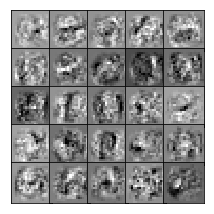

In [469]:
visualizationHandwrittenDigits(Theta1)

# Implement Predict
---
After training the neural network, we would like to use it to predict the labels. You will now implement the "predict" function to use the neural network to predict the labels of the training set. This lets you compute the training set accuracy.

In [470]:
# 使用训练后的权重参数进行预测，查看准确率
# y[y==10] = 0
#print(classification_report(y, predict(Theta1, Theta2, X)))
# or
print('Accuracy = {0}%'.format(np.mean(y==np.matrix(predict(Theta1, Theta2, X)).T) * 100))

Accuracy = 99.58%



Displaying Example Image



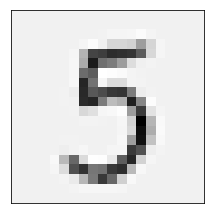


Neural Network Prediction: [5] (digit 5)

Press `Ctrl + Enter` to re-predict with different digit


In [654]:
# To give you an idea of the network's output, you can run through the examples one at the a time to see what it is predicting.
# You can aslo press `ctrl+enter` multiple times to see the results of multiple predictions.

m, n = X.shape

# Randomly example
rp = np.random.randint(m)

print('\nDisplaying Example Image\n');
visualizationHandwrittenDigits(X[rp:rp+1, :])

pred = predict(Theta1, Theta2, X[rp:rp+1, :])
actual_label = y[rp, 0]
print('\nNeural Network Prediction: {0} (digit {1})'.format(pred, actual_label))
print()
print('Press `Ctrl + Enter` to re-predict with different digit')